In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import umap
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader

import pytorch_lightning as pl

from deeptime.models.oneclass.linear import LinearOCC
from deeptime.models.representation import LinearAutoEncoder
from deeptime.data import BaseDataset

from sktime.datasets import load_UCR_UEA_dataset

from sklearn.svm import OneClassSVM
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [3]:
DATASETS = [
    'Yoga',
    # 'WormsTwoClass',
    # 'Wine',
    # 'Wafer',
    # 'TwoLeadECG',
    # 'Strawberry',
    # 'SemgHandGenderCh2', 
    # 'BeetleFly',
    # 'BirdChicken',
    # 'Computers',
    # 'DistalPhalanxOutlineCorrect',
    # 'Earthquakes',
    # 'ECG200',
    # 'ECGFiveDays',
    # 'FordA',
    # 'FordB',
    # 'HandOutlines',
    # 'ItalyPowerDemand', 
    # 'MiddlePhalanxOutlineCorrect',
    # 'Chinatown',
    # 'FreezerRegularTrain',
    # 'FreezerSmallTrain',
    # 'GunPointAgeSpan',
    # 'GunPointMaleVersusFemale',
    # 'GunPointOldVersusYoung',
    # 'PowerCons',
    # 'Coffee',
    # 'Ham',
    # 'Herring',
    # 'Lightning2',
    # 'MoteStrain',
    # 'PhalangesOutlinesCorrect',
    # 'ProximalPhalanxOutlineCorrect',
    # 'ShapeletSim',
    # 'SonyAIBORobotSurface1',
    # 'SonyAIBORobotSurface2',
    # 'ToeSegmentation1',
    # 'ToeSegmentation2',
    # 'HouseTwenty'
]

In [4]:
dataset = 'Yoga'
x_train, y_train = load_UCR_UEA_dataset(name=dataset, split='train')
# Since the features from the sktime are instatiated as objects we have to manually convert them
y_train = np.array(y_train, dtype=np.int32)

sequence_length = x_train.values[0][0].shape[0]

x_test, y_test = load_UCR_UEA_dataset(name=dataset, split='test')
y_test = np.array(y_test, dtype='int32') # Fixing the labels type

x_train_transformed = []
for val in x_train.values:
    x_train_transformed.append(val[0].tolist())
x_train = np.array(x_train_transformed)

x_test_transformed = []
for val in x_test.values:
    x_test_transformed.append(val[0].tolist())
x_test = np.array(x_test_transformed)

train_dataset = BaseDataset(x=x_train, y=y_train)
train_loader = DataLoader(train_dataset, batch_size=32)

model = LinearAutoEncoder(input_dim=sequence_length, latent_dim=32)
model.load_state_dict(torch.load(f'../../../pretrain/representation/{dataset}/linear_autoencoder.pt'))

# x_train_ = x_train[y_train == label]
# y_train_ = y_train[y_train == label]

<All keys matched successfully>

In [4]:
representations = []
for x, _ in train_loader:
    x_hat, z = model(x)
    representations.extend(z.tolist())
representations = np.array(representations)

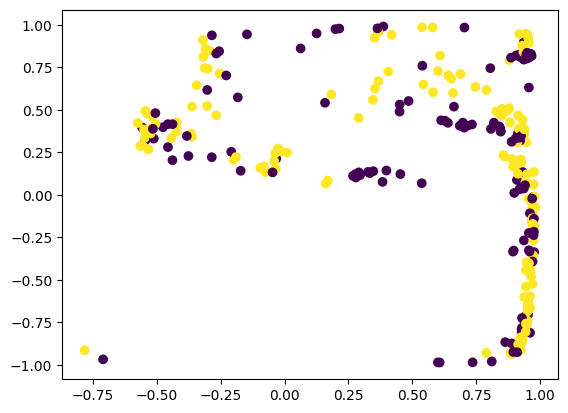

In [5]:
plt.scatter(representations[:, 0], representations[:, 1], c=y_train)

In [6]:
model = LinearOCC(
    input_dim=sequence_length,
    latent_dim=32,
    radius=0.35,
    learning_rate=5e-4
)

model.center = torch.tensor([0. for _ in range(32)])

model.load_pretrained_weights(
    f'../../../pretrain/representation/{dataset}/linear_autoencoder.pt'
)

In [7]:
x_train_ = x_train[y_train == 1]
y_train_ = y_train[y_train == 1]

train_dataset = BaseDataset(x=x_train, y=y_train)
train_loader = DataLoader(train_dataset, batch_size=32)

occ_labels = [1 if x == 1 else -1 for x in y_test]
        
test_dataset = BaseDataset(x=x_test, y=np.array(occ_labels))
test_loader = DataLoader(test_dataset, batch_size=32)

trainer = pl.Trainer(
    max_epochs=1000,
    accelerator='gpu',
    devices=-1,
)

trainer.fit(model, train_dataloaders=train_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params
------------------------------------
0 | e    | Sequential | 479 K 
------------------------------------
479 K     Trainable params
0         Non-trainable params
479 K     Total params
1.916     Total estimated model params size (MB)


Epoch 999: 100%|███████████████████████████████| 10/10 [00:00<00:00, 67.57it/s, loss=0.903, v_num=17, train_loss=0.895]

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|███████████████████████████████| 10/10 [00:00<00:00, 54.35it/s, loss=0.903, v_num=17, train_loss=0.895]


In [15]:
representations = []
for x, _ in test_loader:
    z = model(x)
    representations.extend(z.tolist())
representations = np.array(representations)

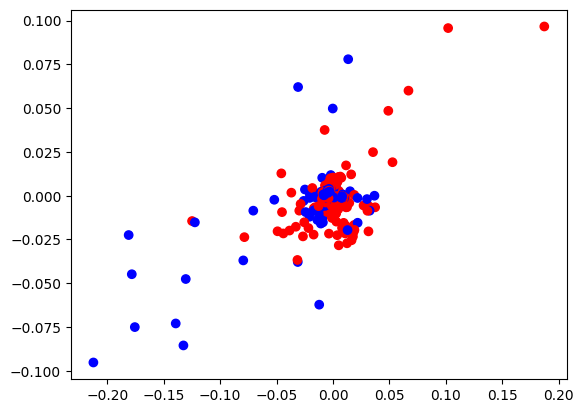

In [22]:
plt.scatter(representations[:, 0], representations[:, 1], c=['red' if label == 1 else 'blue' for label in occ_labels])

In [9]:
trainer.test(model, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████| 94/94 [00:01<00:00, 70.69it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_f1_score        │    0.6140529902477077     │
└───────────────────────────┴───────────────────────────┘

[{'val_f1_score': 0.6140529902477077}]

In [11]:
for dataset in DATASETS:
    print(f'\tDownloading the {dataset} dataset...')
    x_train, y_train = load_UCR_UEA_dataset(name=dataset, split='train')
    # Since the features from the sktime are instatiated as objects we have to manually convert them
    y_train = np.array(y_train, dtype=np.int32)

    sequence_length = x_train.values[0][0].shape[0]

    x_test, y_test = load_UCR_UEA_dataset(name=dataset, split='test')
    y_test = np.array(y_test, dtype='int32') # Fixing the labels type
    print(f'\t\tDownload completed!')

    print('\tTransforming data to the correct format...')
    x_train_transformed = []
    for val in x_train.values:
        x_train_transformed.append(val[0].tolist())
    x_train = np.array(x_train_transformed)

    x_test_transformed = []
    for val in x_test.values:
        x_test_transformed.append(val[0].tolist())
    x_test = np.array(x_test_transformed)
    print('\t\tTransform completed!')

    print('\tStarting the classifier...')
    unique_labels = np.unique(y_train)

    for label in unique_labels:
        print(f'\t\tClassifying the label {label}...')
        
        x_train_ = x_train[y_train == label]
        y_train_ = y_train[y_train == label]

        occ_labels = [1 if x == label else -1 for x in y_test]

        train_dataset = BaseDataset(x=x_train, y=y_train)
        train_loader = DataLoader(train_dataset, batch_size=32)
        
        test_dataset = BaseDataset(x=x_test, y=np.array(occ_labels))
        test_loader = DataLoader(test_dataset, batch_size=32)

        model = LinearOCC(
            input_dim=sequence_length,
            latent_dim=32,
            radius=1,
        )

        model.load_pretrained_weights(
            f'../../../pretrain/representation/{dataset}/linear_autoencoder.pt'
        )
        # Define the center
        model._init_center(train_loader)
        
        for x, _ in train_loader:
            z = model(x)
            distances = torch.sum((z - model.center) ** 2, dim=1)
            scores = distances - model.R ** 2
            print(scores)
            loss = torch.mean(torch.max(torch.exp(scores), scores + 1))
            print(loss)
            # print(model.center)
            
            break
        break
        # trainer = pl.Trainer(
        #     max_epochs=100,
        #     accelerator='gpu',
        #     devices=-1,
        # )
        
        # trainer.fit(model, train_dataloaders=train_loader)

        # print(f'\t\tReport:')
        # # print(f'\t\t\tAccuracy Score = {accuracy_score(occ_labels, result_labels)}')
        # print(f'\t\t\tF1 Score = {f1_score(occ_labels, result_labels)}')

    print('-' * 100)

		Download completed!
	Transforming data to the correct format...
		Transform completed!
	Starting the classifier...
		Classifying the label 1...
tensor([243078.7344, 242967.3125, 228835.6250, 234592.3281, 237974.5156,
        240657.9688, 238359.2188, 238005.4844, 235088.0625, 236762.6719,
        241024.5781, 240185.6250, 233192.8906, 240238.6250, 234355.3594,
        234100.7500, 241885.3125, 239919.4375, 238963.4062, 245683.9375,
        246488.3125, 232068.4688, 233685.4688, 243251.5469, 244260.6719,
        235323.6875, 244628.5156, 245122.2344, 233754.2969, 242841.1250,
        244027.6406, 235051.3438], grad_fn=<SubBackward0>)
tensor(inf, grad_fn=<MeanBackward0>)
----------------------------------------------------------------------------------------------------
